类别权重： {0: 0.9999958333333333, 1: 1.0000041667013893}


C:\Users\李凯航\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 152s 81ms/step - accuracy: 0.8958 - loss: 0.2732
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 149s 80ms/step - accuracy: 0.9859 - loss: 0.0391
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 149s 79ms/step - accuracy: 0.9931 - loss: 0.0163
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 148s 79ms/step - accuracy: 0.9943 - loss: 0.0110
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 148s 79ms/step - accuracy: 0.9949 - loss: 0.0088
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step
正确率是：              precision    recall  f1-score   support

           0       0.94      0.61      0.74     50000
           1       0.71      0.96      0.82     50000

    accuracy                           0.79    100000
   macro avg       0.82      0.79      0.78    100000
weighted avg       0.82      0.79      0.78    100000



E:\app\anaconda\anaconda-con\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\app\anaconda\anaconda-con\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\app\anaconda\anaconda-con\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\app\anaconda\anaconda-con\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38453 (\N{CJK UNIFIED IDEOGRAPH-9635}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


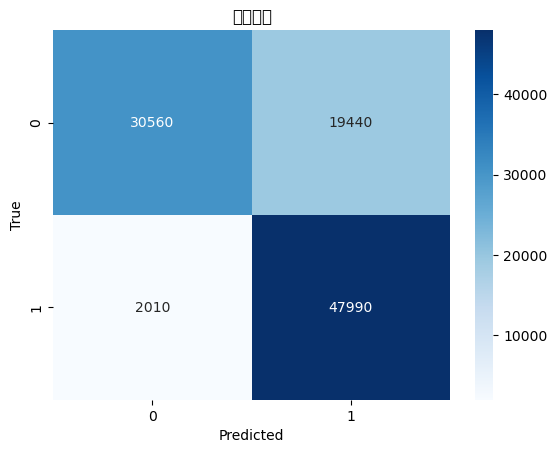

In [4]:
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack, csr_matrix

def extract_features(url): #结构化特征，优化使用
    features = {} #创建空字典
    url = str(url) #确保url都是字符串
    features['url_length'] = len(url) # 看长度
    features['count_dots'] = url.count('.') #看点的数量
    features['count_hyphens'] = url.count('-') #看横杠的数量
    suspicious_keywords = ['login', 'secure', 'account', 'verify', 'password', 'update', 'banking'] #看敏感词在恶意网站中的敏感词
    features['count_suspicious_words'] = sum( #这里是数组的原因是我们的url不止一个
        1 for kw in suspicious_keywords if kw in url.lower()
    ) #遍历一遍看有多少敏感词，统计出来个数2
    return features

data=pd.read_csv('E:/作业/杂物/数据集/111_fixed.csv',encoding='ISO-8859-1')
data = data.dropna(subset=['url', 'label'])
data = data[data['url'].astype(str).str.strip() != '']
x=data['url']
y=data['label'] #加载数据
xx = pd.DataFrame([extract_features(u) for u in x])
vec=TfidfVectorizer() #创建向量器
x_vec=vec.fit_transform(x) #转化x
y_np = np.array(y)
weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_np),y=y_np)
class_weights = {i: weights[i] for i in range(len(weights))}
print("类别权重：", class_weights)#计算权重解决模型宁可错杀绝不放过的特征
scaler = MinMaxScaler()
structured_train_scaled = scaler.fit_transform(xx) #防止数据特征本身太大或太小太影响结果判断转换成介于(0,1)
structured_train_sparse = csr_matrix(structured_train_scaled) #转换成稀疏矩阵进行拼接因为前面 x_vec（TF-IDF 特征）就是稀疏矩阵必须跟它格式一样才能拼接！
x_final = hstack([x_vec, structured_train_sparse]) #合并数据将特征和数据本身进行合并变成一个

sq=Sequential()
sq.add(Dense(64,input_dim=x_final.shape[1],activation='relu'))
sq.add(Dense(32,activation='relu'))
sq.add(Dense(1,activation='sigmoid'))

sq.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
sq.fit(x_final,y,epochs=5,batch_size=128,class_weight=class_weights)

data2=pd.read_csv('E:/作业/杂物/数据集/balanced_test_set.csv', encoding='gb18030')
x1=data2['url']
y1=data2['label'] #读取测试数据
xx1 = pd.DataFrame([extract_features(u) for u in x1])
x1_vec = vec.transform(x1) #测试数据也要使用相同向量器进行转化

structured_scaled2 = scaler.transform(xx1) #不用再fit了！！！我们应当使用之前的规则
structured_sparse2 = csr_matrix(structured_scaled2) #测试集数据也应该这样做
x_final2 = hstack([x1_vec, structured_sparse2]) 

y_predict = sq.predict(x_final2) #得到预测结果
y_predict = (y_predict > 0.5).astype(int)  # 概率转标签

report=classification_report(y1.values,y_predict) #判断准确度
print(f"正确率是：{report}")